In [1]:
## Alyssa Poletti APRP ##
## Adapted from Aaron Levine, adapted from Mark Zelinka ##


"""
You will need to download the following lat-lon datasets for every model of interest:
clt, rsdt, rsut, rsutcs, rsds, rsdscs, pr
from the CMIP6 Data repository. 

Please change the file paths to your direction
"""


"""
This script demonstrates creating climatologies and using the APRP method to compute TOA SW radiation anomalies
due to individual components from differenct CMIP6 simulations.
Based on script written by Mark Zelinka (zelinka1@llnl.gov) on 31 October 2018
Updated for local climatologies from CMIP6 archive and xarray by Aaron Levine April 2020
Reference:
Taylor, K. E. et al. (2007), Estimating shortwave radiative forcing and response in 
    climate models, J. Clim., 20(11), 2530-2543, doi:10.1175/JCLI4143.1.  
Script outline:
    1 cell, import
    3 cells, locally defined functions for APRP
    1 cell, create climatology (save output)
    1 cell, APRP calculations and regridding (save output)
    Rest of cells, visualiztion examples of APRP
"""
### IMPORT STUFF ###
#=====================

import numpy as np
from numpy.ma import masked_where
import pylab as pl
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cartopy.crs as ccrs
import glob
import xesmf as xe

#import util
#import seaborn as sns
#from mpl_toolkits.basemap import Basemap
#import cdms2 as cdms
#import cdutil
#import MV2 as MV
#Check is we need MV2, util, seaborn, or xesmf

In [27]:
### Local Read Functions by A Levine ###

# This is the first version of a function to output data from the local cmip6
# archive as an xarray data set for analysis
# Currently designed to be given a model, experiment, and variable (plus table)
# as inputs.  Will find the number of ensemble members available.
# If unspecified will use all ensemble members
# Future updates will add functionality

def local_cmip6_read(exp, model, variable, freq, no_esm=False):
    
    general_folder = '/home/disk/eos9/cmip6/' #### Change to your path ####
    ff = general_folder + exp +'/' + model + '/' + variable +'/'
    fpre = ff + variable + '_' + freq + '_' + model + '_'+ exp + '_r*.nc'
    
    if not no_esm:
        no_ens = list_ensembles(exp, model, variable, freq)
    else:
        no_ens = no_esm
        
    #use previously generated list of ensemble members to create a new dataset over ensemble members
    ens_list=[]
    
    for e in no_ens:
        rz = str(e)
        ens = 'ens%d' % e
        mfl = fpre + rz +'i1p1*_gn*'
        
        ens_list.append(xr.open_mfdataset(mfl))
        
    ds=xr.concat(ens_list, dim='ensemble')

    return ds 

def local_cmip6_read_ag(exp,model,variable,freq,no_esm=False):
    
    general_folder = '/home/disk/eos9/cmip6/' #### Change to your path ####
    ff = general_folder + exp +'/' + model + '/' + variable +'/'
    fpre = ff + variable + '_' + freq + '_' + model + '_'+ exp + '_r'
    
    if not no_esm:
        no_ens=list_ensembles(exp, model, variable, freq)
        
    else:
        no_ens=no_esm
        
    #use previously generated list of ensemble members to create a new dataset over ensemble members
    ens_list=[]
    
    for e in no_ens:
        rz=str(e)
        ens= 'ens%d' % e
        mfl=fpre + rz +'i1p1f*'
        
        ens_list.append(xr.open_mfdataset(mfl))
        
    ds=xr.concat(ens_list, dim='ensemble')

    return ds 

## Local Read Function that I use ##
def local_cmip6_read_new(exp, model, variable, freq, variant):
    
    general_folder = '/home/disk/eos9/cmip6/' #### Change to your path ####
    ff = general_folder + exp +'/' + model + '/' + variable +'/'
    
    if model == 'IPSL-CM6A-LR':
        fname = ff + variable + '_' + freq + '_' + model + '_'+ exp + '_' + variant + '_gr_185001-214912.nc'
    else:
        fname = ff + variable + '_' + freq + '_' + model + '_'+ exp + '_' + variant + '*'
        
    ds=xr.open_mfdataset(fname, concat_dim='time')

    return ds 

def local_cmip6_read_hs(exp, model, variable, freq, variant):
    
    general_folder = '/home/disk/eos9/cmip6/' #### Change to your path ####
    ff = general_folder + exp +'/' + model + '/' + variable +'/'
    fname = ff + variable + '_' + freq + '_' + model + '_'+ exp + '_r1i1p1f*'

        
    ds=xr.open_mfdataset(fname, concat_dim='time')

    return ds 

#This function finds the number of ensemble members present in our archives
def find_num_ensembles(exp,model,variable,freq):
    
    general_folder = '/home/disk/eos9/cmip6/' #### Change to your path ####
    ff = general_folder + exp +'/' + model + '/' + variable +'/'
    
    #expanding to files in an experiment, model, variable
    files = [fi for fi in glob.glob(ff + variable + "_" + freq +"*")]
    
    #Now need to find the number of ensemble members.
    #All files have the same prefix and location pattern
    #so add up characters before r*i1p1f1 (can be modified later to account for other options)
    fpre = ff+variable + '_' + freq + '_' + model + '_'+ exp + '_r'
    
    #cut length of file name to just be r*i*p*f*
    fprel = len(fpre)
    filestrunc = [fi[fprel-1:fprel+3] for fi in files]
    filestrunc1 = np.array(filestrunc)
    ens_name = np.unique(filestrunc1)
    no_ens = len(ens_name)
    
    return no_ens


#This function finds the number of ensemble members present in our archives
def find_models(exp,variable):
    general_folder='/home/disk/eos9/cmip6/' #### Change to your path ####
    fe=general_folder + exp +'/'
    #find models (each model should have its own folder)
    amodels= [fi for fi in glob.glob(fe +"*")]
    #check if variable available in model
    models=[]
    for fi in amodels:
        fm= fi + '/'+ variable + '/'
        if os.path.isdir(fm):
            fprel=len(fe)
            mi=fi[fprel:]
            models.append(mi)
    return models

#This function finds the number of ensemble members present in our archives
def list_ensembles(exp,model,variable,freq):
    general_folder='/home/disk/eos9/cmip6/' #### Change to your path ####
    ff=general_folder + exp +'/' + model + '/' + variable +'/'
    #expanding to files in an experiment, model, variable
    files= [fi for fi in glob.glob(ff + variable + "_" + freq + "*")]
    #Now need to find the number of ensemble members.
    #All files have the same prefix and location pattern
    #so add up characters before r*i1p1f1 (can be modified later to account for other options)

    fpre=ff+variable + '_' + freq + '_' + model + '_'+ exp + '_r'
    #cut length of file name to just be r*i*p*f*
    fprel=len(fpre)
    filestrunc=[fi[fprel-1:fprel+3] for fi in files]
    filestrunc1=np.array(filestrunc)
    ens_name=np.unique(filestrunc1)
    rnames=[]
    for e in ens_name:
        ens_name1=str(e)
        rnames1=ens_name1.find('i')
        a=e[1:rnames1]
        rnames.append(a)
    rnames1=list(map(int,rnames))
    return rnames1

#This function finds the models with any data downloaded for a given experiments
def find_models_all(exp):
    general_folder='/home/disk/eos9/cmip6/' #### Change to your path ####
    fe=general_folder + exp +'/'
    #find models (each model should have its own folder)
    amodels= [fi for fi in glob.glob(fe +"*")]
    fprel=len(fe)
    models=[]
    for fi in amodels:
        mi=fi[fprel:]
        models.append(mi)
    return models

#This function is an updated read for all physics
def local_cmip6_read_ap(exp,model,variable,freq,no_esm=False):
    
    general_folder='/home/disk/eos9/cmip6/' #### Change to your path ####
    ff=general_folder + exp +'/' + model + '/' + variable +'/'
    fpre=ff+variable + '_' + freq + '_' + model + '_'+ exp + '_r'
    if not no_esm:
        no_ens=list_ensembles(exp,model,variable,freq)
    else:
        no_ens=no_esm
    #use previously generated list of ensemble members to create a new dataset over ensemble members
    ens_list=[]
    for e in no_ens:
        rz=str(e)
        ens= 'ens%d' % e
        mfl=fpre + rz +'i1p*f*'
        
        ens_list.append(xr.open_mfdataset(mfl))
    ds=xr.concat(ens_list, dim='ensemble')
#    ds=mfl
    return ds 

In [28]:
### Here are the APRP functions ###
## Albedo ##

def albedo(c, a_clr, a_oc, mu_clr, mu_cld, ga_clr, ga_cld):

    """
    This function is called by APRP
    Equation numbers refer to Taylor et al. (2007)
    """

    mu_oc = mu_clr * mu_cld # Eq. 14
    ga_oc = 1 - ( 1 - ga_clr ) * ( 1 - ga_cld ) # Eq. 13
    A_clr = ( mu_clr * ga_clr ) + ( ( mu_clr * a_clr * ( 1 - ga_clr )**2 ) / ( 1 - ( a_clr * ga_clr ) ) ) # Eq. 7
    A_oc = ( mu_oc * ga_oc ) + ( ( mu_oc * a_oc * ( 1-ga_oc )**2 ) / ( 1 - ( a_oc * ga_oc ) ) ) # Eq. 7
    A = ( 1 - c ) * A_clr + c * A_oc # Eq. 15

    return A 

In [29]:
### Here are the APRP functions ###
## Parameters ##

def parameters(SWupsfccs, SWdnsfccs, SWdn, SWupcs, SWupsfcoc, SWdnsfcoc, SWupoc):

    """
    This function is called by APRP
    Equation numbers refer to Taylor et al. (2007)
    """
    
    #calculating clear sky para
    a_clr = SWupsfccs / SWdnsfccs # albedo
    Q = SWdnsfccs / SWdn # ratio of incident sfc flux to TOA insolation
    mu_clr = SWupcs / SWdn + Q * ( 1 - a_clr ) # Eq. 9
    ga_clr = ( mu_clr - Q ) / ( mu_clr - a_clr * Q ) # Eq. 10

    # calculating overcast para
    a_oc = SWupsfcoc / SWdnsfcoc # albedo
    Q = SWdnsfcoc / SWdn # ratio of incident sfc flux to TOA insolation
    mu_oc = SWupoc / SWdn + Q * ( 1 - a_oc ) # Eq. 9
    ga_oc = ( mu_oc - Q ) / ( mu_oc - a_oc * Q ) # Eq. 10

    # calculating cloud parameters through clear sky and overcast parameters
    mu_cld = mu_oc / mu_clr  # Eq. 14 sometimes this is greater than 1??
    ga_cld =( ga_oc - 1 ) / ( 1 - ga_clr ) + 1  # Eq. 13

    return (a_clr, mu_clr, ga_clr, a_oc, mu_cld, ga_cld)

In [30]:
### Here are the APRP functions ###
## APRP Routine ##

def APRP(ctl_clt, ctl_rsdt, ctl_rsut, ctl_rsutcs, ctl_rsds, ctl_rsus, ctl_rsdscs, ctl_rsuscs,
         pert_clt, pert_rsdt, pert_rsut, pert_rsutcs, pert_rsds, pert_rsus, pert_rsdscs, pert_rsuscs):
    """
    Perform APRP calculations 
    
    Reference: Taylor, K. E. et al. (2007), Estimating shortwave radiative forcing and response in 
    climate models, J. Clim., 20(11), 2530-2543, doi:10.1175/JCLI4143.1.
    
    input: total cloud cover and SW radiative fluxes at TOA and SFC for clear- and all-sky conditions
           -standard CMIP nomenclature, with prefixes that refer to the control (ctl_*) and perturbed climate (pert_*) 
    
    output: TOA SW anomalies due to changes in:
            -surface albedo (for all-, clear-, and overcast-sky conditions)
            -clouds (total change and contributions from changing cloud cover, scattering, and absorption)
            -non-cloud atmosphere (e.g., from changes in water vapor, aerosols, ozone)
            
    functions called: parameters() and albedo()
    """
    
    # Make sure the cld fractions are expressed as fraction and not percent
    
    #if MV.max(ctl_clt)>1.:
    #    ctl_clt=ctl_clt/100.
    #if MV.max(pert_clt)>1.:
    #    pert_clt=pert_clt/100.
        
    # same thing but using numpy max function rather than MV2
    # also changed MV2.masked_where to numpy.ma.masked_where and numpy.where
    
    if np.max(ctl_clt) > 1.:
        ctl_clt = ctl_clt / 100.
    if np.max(pert_clt) > 1.:
        pert_clt = pert_clt / 100.

    # Derive overcast conditions
    ctl_rsut_cld = ( 1 / ctl_clt ) * ( ctl_rsut - ( 1 - ctl_clt ) * ctl_rsutcs )
    ctl_rsds_cld = ( 1 / ctl_clt ) * ( ctl_rsds - ( 1 - ctl_clt ) * ctl_rsdscs )
    ctl_rsus_cld = ( 1 / ctl_clt ) * ( ctl_rsus - ( 1 - ctl_clt ) * ctl_rsuscs )
    pert_rsut_cld = ( 1 / pert_clt ) * ( pert_rsut - ( 1 - pert_clt ) * pert_rsutcs )
    pert_rsds_cld = ( 1 / pert_clt ) * ( pert_rsds - ( 1 - pert_clt ) * pert_rsdscs )
    pert_rsus_cld = ( 1 / pert_clt ) * ( pert_rsus - ( 1-pert_clt ) * pert_rsuscs )

    # Mask these where values are unphysical   
    ctl_rsds_cld = masked_where(ctl_rsds_cld > ctl_rsds, ctl_rsds_cld)
    ctl_rsus_cld = masked_where(ctl_rsus_cld > ctl_rsus, ctl_rsus_cld)
    ctl_rsut_cld = masked_where(ctl_rsut_cld < 0, ctl_rsut_cld)
    ctl_rsds_cld = masked_where(ctl_rsds_cld < 0, ctl_rsds_cld)
    ctl_rsus_cld = masked_where(ctl_rsus_cld < 0, ctl_rsus_cld)

    pert_rsds_cld = masked_where(pert_rsds_cld > pert_rsds, pert_rsds_cld)
    pert_rsus_cld = masked_where(pert_rsus_cld > pert_rsus, pert_rsus_cld)
    pert_rsut_cld = masked_where(pert_rsut_cld < 0, pert_rsut_cld)
    pert_rsds_cld = masked_where(pert_rsds_cld < 0, pert_rsds_cld)
    pert_rsus_cld = masked_where(pert_rsus_cld < 0, pert_rsus_cld)    

    ## NOW THE FORMAL APRP CALCULATIONS:
    a_clr1, mu_clr1, ga_clr1, a_oc1, mu_cld1, ga_cld1 = \
        parameters(ctl_rsuscs, ctl_rsdscs, ctl_rsdt, ctl_rsutcs, ctl_rsus_cld, ctl_rsds_cld, ctl_rsut_cld) # control
    a_clr2, mu_clr2, ga_clr2, a_oc2, mu_cld2, ga_cld2 = \
        parameters(pert_rsuscs, pert_rsdscs, pert_rsdt, pert_rsutcs, pert_rsus_cld, pert_rsds_cld, pert_rsut_cld) # perturbed    

    ## Taylor et al. (2007) Eqn. 12b:
    A_1 = albedo(ctl_clt, a_clr1, a_oc1, mu_clr1, mu_cld1, ga_clr1, ga_cld1)
    A_2 = albedo(pert_clt, a_clr2, a_oc2, mu_clr2, mu_cld2, ga_clr2, ga_cld2)

    # need to add spaces here as well....
    dA_amt_cld=     0.5*(albedo(pert_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(ctl_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2))
    dA_a_clr=       0.5*(albedo(ctl_clt,a_clr2,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr1,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2))
    dA_a_oc=        0.5*(albedo(ctl_clt,a_clr1,a_oc2,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc1,mu_clr2,mu_cld2,ga_clr2,ga_cld2))
    dA_abs_noncld=  0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr2,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr1,mu_cld2,ga_clr2,ga_cld2))
    dA_abs_cld=     0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld2,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld1,ga_clr2,ga_cld2))
    dA_scat_noncld= 0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr2,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr1,ga_cld2))
    dA_scat_cld=    0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld2)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld1))

    # if the cld fraction is less than 2%, set fields to be zero
    dA_amt_cld = np.where(ctl_clt < 0.02, 0., dA_amt_cld)
    dA_amt_cld = np.where(pert_clt < 0.02, 0., dA_amt_cld)
    dA_a_oc = np.where(ctl_clt < 0.02, 0., dA_a_oc)
    dA_a_oc = np.where(pert_clt < 0.02, 0., dA_a_oc)
    dA_abs_cld = np.where(ctl_clt < 0.02, 0., dA_abs_cld)
    dA_abs_cld = np.where(pert_clt < 0.02, 0., dA_abs_cld)
    dA_scat_cld = np.where(ctl_clt < 0.02, 0., dA_scat_cld)
    dA_scat_cld = np.where(pert_clt < 0.02, 0., dA_scat_cld)

    dA_a = dA_a_clr + dA_a_oc
    dA_cld = dA_abs_cld + dA_scat_cld + dA_amt_cld
    dA_noncld = dA_abs_noncld + dA_scat_noncld

    ## TOA SW Anomalies due to Surface Albedo Anomalies
    sfc_alb = -dA_a * ctl_rsdt
    sfc_alb_clr = -dA_a_clr * ctl_rsdt   
    sfc_alb_oc = -dA_a_oc * ctl_rsdt

    ## TOA SW Anomalies due to Cloud Anomalies
    cld = -dA_cld * ctl_rsdt
    cld_amt = -dA_amt_cld * ctl_rsdt    
    cld_scat = -dA_scat_cld * ctl_rsdt
    cld_abs = -dA_abs_cld * ctl_rsdt

    ## TOA SW Anomalies due to Non-cloud Anomalies
    noncld = -dA_noncld * ctl_rsdt
    noncld_scat = -dA_scat_noncld * ctl_rsdt  
    noncld_abs = -dA_abs_noncld * ctl_rsdt

    # set fields to zero when incoming solar radiation is zero
    dA_a = np.where(ctl_rsdt < 0.1, 0., dA_a)
    dA_noncld = np.where(ctl_rsdt<0.1, 0., dA_noncld)
    sfc_alb = np.where(ctl_rsdt < 0.1, 0., sfc_alb)
    cld = np.where(ctl_rsdt < 0.1, 0., cld)
    noncld = np.where(ctl_rsdt < 0.1, 0., noncld)
    sfc_alb_clr = np.where(ctl_rsdt < 0.1, 0., sfc_alb_clr)
    sfc_alb_oc = np.where(ctl_rsdt < 0.1, 0., sfc_alb_oc)
    cld_amt = np.where(ctl_rsdt < 0.1, 0., cld_amt)
    cld_scat = np.where(ctl_rsdt < 0.1, 0., cld_scat)
    cld_abs = np.where(ctl_rsdt < 0.1, 0., cld_abs)
    noncld_scat = np.where(ctl_rsdt < 0.1, 0., noncld_scat)
    noncld_abs = np.where(ctl_rsdt < 0.1, 0., noncld_abs)

    # give fields axes attributes
#    sfc_alb.setAxisList(pert_clt.getAxisList())
#    sfc_alb_clr.setAxisList(pert_clt.getAxisList())
#    sfc_alb_oc.setAxisList(pert_clt.getAxisList())
#    cld.setAxisList(pert_clt.getAxisList())
#    cld_amt.setAxisList(pert_clt.getAxisList())
#    cld_scat.setAxisList(pert_clt.getAxisList())
#    cld_abs.setAxisList(pert_clt.getAxisList())
#    noncld.setAxisList(pert_clt.getAxisList())
#    noncld_scat.setAxisList(pert_clt.getAxisList())
#    noncld_abs.setAxisList(pert_clt.getAxisList())


    # For Xarray need to change them into Data Arrays
    sfc_alb=xr.DataArray(sfc_alb, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    sfc_alb_clr=xr.DataArray(sfc_alb_clr, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    sfc_alb_oc=xr.DataArray(sfc_alb_oc, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    cld=xr.DataArray(cld, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    cld_amt=xr.DataArray(cld_amt, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    cld_scat=xr.DataArray(cld_scat, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    cld_abs=xr.DataArray(cld_abs, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    noncld=xr.DataArray(noncld, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    noncld_scat=xr.DataArray(noncld_scat, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    noncld_abs=xr.DataArray(noncld_abs, dims=['month','lat','lon'],
               coords={'lon':pert_clt.lon,
                      'lat':pert_clt.lat,
                      'month':pert_clt.month})
    
    return (sfc_alb,sfc_alb_clr,sfc_alb_oc,cld,cld_amt,cld_scat,cld_abs,noncld,noncld_scat,noncld_abs)

In [31]:
## Models We're Running this Over ##

exps = ['abrupt-4xCO2'] # Name of Experiment

models = ['CanESM5', 'CESM2', 'MIROC6', 'CNRM-CM6-1', 
          'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0']  # List of Models

variant =   {'CESM2': 'r1i1p1f1',
             'CanESM5': 'r1i1p1f1',
             'GFDL-CM4': 'r1i1p1f1',
             'GFDL-ESM4': 'r1i1p1f1',
             'HadGEM3-GC31-LL': 'r1i1p1f3', #f1 for piControl, f2 for 1pctCO2, f3 for abrupt-4x
             'IPSL-CM6A-LR': 'r1i1p1f1',
             'BCC-CSM2-MR': 'r1i1p1f1', 
             'BCC-ESM1': 'r1i1p1f1',
             'CAMS-CSM1-0': 'r1i1p1f1',
             'CESM2-WACCM': 'r1i1p1f1',
             'CNRM-CM6-1': 'r1i1p1f2',
             'CNRM-ESM2-1': 'r1i1p1f2',
             'E3SM-1-0': 'r1i1p1f1',
             'EC-Earth3-Veg': 'r1i1p1f1',
             'EC-Earth3': 'r1i1p1f1',
             'GISS-E2-1-G': 'r1i1p1f1',
             'GISS-E2-1-H': 'r1i1p1f1',
             'MIROC6': 'r1i1p1f1',
             'MIROC-ES2L': 'r1i1p1f2',
             'MRI-ESM2-0': 'r1i1p1f1',
             'SAM0-UNICON': 'r1i1p1f1',
             'UKESM1-0-LL': 'r1i1p1f2',
             }

variables = ['clt','rsdt','rsut','rsutcs','rsds','rsus','rsdscs','rsuscs','pr']
nvars = len(variables)

In [37]:
### Calculate and Output Monthly Climatology ###

# Cell of calculating monthly climatologies for a given period
# Create climatology for SSP585 and output netcdf file from it
# This cell accomplishes this for a given set of experiments for all models that have


"""
the variables needed for APRP
variables=['clt','rsdt','rsut','rsutcs','rsds','rsus','rsdscs','rsuscs']}
"""

# Most models run from 1850 to 2000
sp1 = ['1850-01','1871-01'] #First month of period 
ep1 = ['1870-12','2000-12'] #End of Period

# CESM2 runs from 0001 to 0150
sp2 = ['0001-01','0021-01'] #First month of period 
ep2 = ['0020-12','0150-12'] #End of Period

# MIROC6 runs from 3200 to 3350
sp3 = ['3200-01','3221-01'] #First month of period 
ep3 = ['3220-12','3350-12'] #End of Period

nper = len(sp1)

# time periods by index (rather than date/label)
months   = 12
nyears_s = np.array([0, 21])*months
nyears_e = np.array([20, 150])*months

# List of Experiments
#models = ['MRI-ESM2-0']

# Output location
folder='/home/disk/p/apolet/SummerCode/cmip6_climatology/' ### Change to your path ###

# Finds and Saves Climatology of Each Model
for model in models:
    print(model) #print commands inserted just to keep track of progress
    
    for exp in exps:
        print(exp) #print experiment
        
        for var in variables:

            #Test for availability
            nens = find_num_ensembles(exp=exp, model=model, variable=var, freq='Amon')
            
            if nens == 0: #We don't have variable, don't create climatology
                print(var, 'not found')
                continue
                
            else: 
                print(var)
                try:
                    
                    #read in all ensemble members
                    ds = local_cmip6_read_new(exp=exp, model=model, variable=var, freq='Amon', variant=variant[model])
                    
                    
                except:
                    # read error
                    print([model + ' ' + exp + ' ' + var + ' read error'])
                    continue
                    
            #Find climatology based on period
            for p in range (0, nper):
                

                
                if model == 'CESM2':
                    sdstr = sp2[p] # from 0001-0150
                    edstr = ep2[p]
                elif model == 'MIROC6':
                    sdstr = sp3[p] # from 3200-3350
                    edstr = ep3[p]
                else:
                    sdstr = sp1[p] # from 1850-2000
                    edstr = ep1[p]


                try:
                    dsper = ds.sel(time = slice(sdstr, edstr))
                    
                except:
                    #Issue with date-time and timestamp--Use for IPSL and MRI to correct
                    #Replace with time coordinate from Candanian model
                    ds2 = ds.assign_coords(time=pd.date_range(start='1850-01-01', end='2149-12-31', freq='M'))
                    dsper = ds2.sel(time=slice(sdstr, edstr))
                    
                #Using xarray
                avgdataC = dsper.groupby('time.month').mean('time')
                
                # only one ensemble member downloaded
                climatology = avgdataC
                outfile = folder + exp + '_' + model + '_' + var + '_' + sdstr + '-' + edstr + '_mean_climatology.nc'
                
                #file name for write out
                
                climatology.to_netcdf(path = outfile)
                
    print('mean climatology written')


CanESM5
abrupt-4xCO2
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written
CESM2
abrupt-4xCO2
clt


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'clt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsdt


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsut


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsutcs


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsutcs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsds


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsds' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsus


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsus' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsdscs


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsdscs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsuscs


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsuscs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


pr


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


mean climatology written
MIROC6
abrupt-4xCO2
clt


/usr/lib/python3/dist-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written
CNRM-CM6-1
abrupt-4xCO2
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written
GISS-E2-1-G
abrupt-4xCO2
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written
GISS-E2-1-H
abrupt-4xCO2
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written
IPSL-CM6A-LR
abrupt-4xCO2
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written
MRI-ESM2-0
abrupt-4xCO2
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
mean climatology written


In [39]:
### Calculate and Output Historical/Control Monthly Climatology ###
## same as above but for 1 control period
## here, the control is the historial experiment from 1850-1870

"""
the variables needed for APRP
variables=['clt','rsdt','rsut','rsutcs','rsds','rsus','rsdscs','rsuscs']}
"""


#1851-01-1870-12

sp1 = ['1851-01'] #First month of period 
ep1 = ['1870-12'] #End of Period
nper = len(sp1)

# List of Experiments

exp_hs = ['historical'] # Name of Experiment

#models = ['IPSL-CM6A-LR']

# Output location
folder='/home/disk/p/apolet/SummerCode/cmip6_climatology/' ### Change to your path ###

# Finds and Saves Climatology of Each Model
for model in models:
    print(model) #print commands inserted just to keep track of progress
    
    for exp in exp_hs:
        print(exp) #print experiment
        
        for var in variables:
            
            #Test for availability
            nens = find_num_ensembles(exp=exp, model=model, variable=var, freq='Amon')
            
            if nens == 0: #We don't have variable, don't create climatology
                continue
                
            else: #We have variable
                #local_cmip6_read_hs(exp=exp, model=model, variable=var, freq='Amon', variant=variant[model])
                try:
                    
                    #read in all ensemble members
                    ds = local_cmip6_read_hs(exp=exp, model=model, variable=var, freq='Amon', variant=variant[model])
                    print(var)
                    
                except:
                    
                    print(model + ' ' + exp + ' ' + var + ' read error')
                    continue
                    
            #Find climatology based on period
            for p in range (0,nper):
                
                sdstr = sp1[p]
                edstr = ep1[p]
                
                try:
                    dsper = ds.sel(time = slice(sdstr,edstr))
                    
                except:
                    
                    #Issue with date-time and timestamp--Use for IPSL and MRI to correct
                    #Replace with time coordinate from Candanian model
                    dsC = local_cmip6_read_hs(exp = exp, model = 'CanESM5', variable = var, freq = 'Amon', variant=varient['CanESM5'])
                    ds2 = ds.assign_coords(time = dsC.time)
                    dsper = ds2.sel(time = slice(sdstr,edstr))
                    
                #Using xarray
                avgdataC = dsper.groupby('time.month').mean('time')
                
                #Add average across ensemble members
                #climatology = avgdataC.mean('ensemble')
                #outfile = folder + exp + '_' + model + '_' + var + '_' + sdstr + '-' + edstr + '_ensemblemean_climatology.nc'
                
                # only one ensemble member downloaded
                climatology = avgdataC
                outfile = folder + exp + '_' + model + '_' + var + '_' + sdstr + '-' + edstr + '_mean_climatology.nc'
                
                #file name for write out
                
                climatology.to_netcdf(path = outfile)
                
        print('control climatology written')

CanESM5
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written
CESM2
historical
clt


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'clt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)
/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsdt


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsut


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsutcs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsutcs


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsds' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsds


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsus' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsus


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsdscs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsdscs


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'rsuscs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


rsuscs


/usr/lib/python3/dist-packages/xarray/conventions.py:401: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


pr
control climatology written
MIROC6
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written
CNRM-CM6-1
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written
GISS-E2-1-G
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written
GISS-E2-1-H
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written
IPSL-CM6A-LR
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written
MRI-ESM2-0
historical
clt
rsdt
rsut
rsutcs
rsds
rsus
rsdscs
rsuscs
pr
control climatology written


In [40]:
### APRP Main Routine ###

#reads in climatology data and outputs, xarray dataset of results
#APRP calculated on model native grid, then regridded to a 1x1 grid for intermodel comparison

#Climatology File location
folder = '/home/disk/p/apolet/SummerCode/cmip6_climatology/'

## Needed lists ##
#List of periods start date is first, end date is second.  Need to be the same length

# Most models run from 1850 to 2000

periods1 = [['1850-01','1871-01'], ['1870-12','2000-12']]

# CESM2 runs from 0001 to 0150

periods2 = [['0001-01','0021-01'], ['0020-12','0150-12']]

# MIROC6 runs from 3200 to 3350
periods3 = [['3200-01','3221-01'], ['3220-12','3350-12']]

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
nper = len(periods1[0])

#Initialize Dataset for the whole mm
mmaprp = xr.Dataset()

#Place everything on the same grid for storage later (1x1)
outgrid = xe.util.grid_2d(0,360,1, -90,90,1)

#Output File Location
outfolder = '/home/disk/p/apolet/SummerCode/cmip6_analysis_out/' ### Change to your path ###
outfile_post = '_APRP_frombase_historical_1851-1870.nc'

print(exp)
for i, model in enumerate(models):
    print(model)
    
    #Initialize dataset for model
    aprpper = xr.Dataset()
    
    # APRP looks at discrete changes between two periods, so will define the baseline from historical 1850-1870 climatology
    # Read in baseline
    for var in variables:
        filein = folder + 'historical_' + model + '_' + var + '_1851-01-1870-12_mean_climatology.nc'
        ds = xr.open_dataset(filein)
        data = ds.get(var)
        exec('ctl_' + var + ' = data')
        
    #This is the end of the historical baseline read in
    for p in range(0,nper):
        
        if model == 'CESM2':
            sd = periods2[0][p]
            ed = periods2[1][p]
        elif model == 'MIROC6':
            sd = periods3[0][p]
            ed = periods3[1][p]
        else:
            sd = periods1[0][p]
            ed = periods1[1][p]
        
        #Initialize Dataset for periods
        aprpexp = xr.Dataset()
        
        for exp in exps:
            for var in variables:
                #read in all ensemble means
                filein = folder + exp + '_' + model + '_' + var + '_' + sd + '-' + ed + '_mean_climatology.nc'
                ds = xr.open_dataset(filein)
                data = ds.get(var)
                exec('pert_' + var + ' = data')
                
            #If reading in historical simulation, treat that as control for experiments and skip the rest of this block
            print('Run APRP for Period %d' % p)
            (sfc_alb, sfc_alb_clr, sfc_alb_oc, cld, cld_amt, cld_scat, cld_abs, noncld, noncld_scat, noncld_abs) = APRP(ctl_clt, ctl_rsdt, 
                                                                                                                        ctl_rsut, ctl_rsutcs, 
                                                                                                                        ctl_rsds, ctl_rsus, 
                                                                                                                        ctl_rsdscs, ctl_rsuscs, 
                                                                                                                        pert_clt, pert_rsdt, 
                                                                                                                        pert_rsut, pert_rsutcs, 
                                                                                                                        pert_rsds, pert_rsus, 
                                                                                                                        pert_rsdscs, pert_rsuscs)
            
            #Add a variable for total feedback
            total = sfc_alb + cld + noncld
            
            #Create a Dataset of all output variables for the experiment
            aprpds = xr.Dataset(data_vars={'sfc_alb':(('month','lat','lon'),sfc_alb),
                                           'sfc_alb_clr':(('month','lat','lon'),sfc_alb_clr),
                                           'sfc_alb_oc':(('month','lat','lon'),sfc_alb_oc),
                                           'cld':(('month','lat','lon'),cld),
                                           'cld_amt':(('month','lat','lon'),cld_amt),
                                           'cld_scat':(('month','lat','lon'),cld_scat),
                                           'cld_abs':(('month','lat','lon'),cld_abs),
                                           'noncld':(('month','lat','lon'),noncld),
                                           'noncld_scat':(('month','lat','lon'),noncld_scat),
                                           'noncld_abs':(('month','lat','lon'),noncld_abs),
                                           'total':(('month','lat','lon'),total)},
                                coords={'month':sfc_alb.month,
                                        'lat':sfc_alb.lat,
                                        'lon':sfc_alb.lon})
            
            print('Regridding...')
            regridder = xe.Regridder(aprpds, outgrid, 'bilinear', reuse_weights=True) # bilinear regrid
            aprprg = regridder(aprpds)

            
            # aprpexp=xr.concat([aprpexp,aprprg],dim='Experiment') 
            # concatetinate along the experiment dimension for multiple experiments
            # Create plots for each model and experiment at original grid spacing 
            lons = sfc_alb.lon
            lats = sfc_alb.lat
            LON, LAT = np.meshgrid(lons,lats)
        
        # aprpexp=aprpexp.assign_coords({'Experiment':exps}) 
        # Assigns coordinates to the previous dataset, assumes that the first experiment listed is the control
        
        # combine regridded data from each period into a single dataset
        if p == 0: # initial dataset
            aprpper = aprprg
        elif p > 0: # concat/append each period dataset
            aprpper = xr.concat([aprpper,aprprg], dim='Period')
    
    print('Finished All Periods:', percor)
    aprpper.assign_coords(Period=percor)
    
    # combine regridded data from each model into a single dataset
    if i == 0: # intial dataset
        mmaprp = aprpper
    elif i > 0: # concat/append each model dataset
        mmaprp = xr.concat([mmaprp,aprpper], dim='Model')
    
    # mmaprp=xr.concat([mmaprp,aprprg],dim='Model')
    regridder.clean_weight_file() #clear regridding weighting file for each model

print('Done all Models')
mmaprp = mmaprp.assign_coords(Model=models) #Assigns coordinates to the multimodel dataset

historical
CanESM5
Run APRP for Period 0
Regridding...
Create weight file: bilinear_64x128_180x360.nc
using dimensions ('lat', 'lon') from data variable sfc_alb as the horizontal dimensions for this dataset.
Run APRP for Period 1
Regridding...
Reuse existing file: bilinear_64x128_180x360.nc
using dimensions ('lat', 'lon') from data variable sfc_alb as the horizontal dimensions for this dataset.
Finished All Periods: ['1850-1870', '1871-2000']
Remove file bilinear_64x128_180x360.nc
CESM2
Run APRP for Period 0
Regridding...
Create weight file: bilinear_192x288_180x360.nc
using dimensions ('lat', 'lon') from data variable sfc_alb as the horizontal dimensions for this dataset.
Run APRP for Period 1
Regridding...
Reuse existing file: bilinear_192x288_180x360.nc
using dimensions ('lat', 'lon') from data variable sfc_alb as the horizontal dimensions for this dataset.
Finished All Periods: ['1850-1870', '1871-2000']
Remove file bilinear_192x288_180x360.nc
MIROC6
Run APRP for Period 0
Regriddin

In [41]:
### APRP Results 1D, Editted Indices ###

#Adjust for the fact xESMF makes lat,lon that are coordinates, not dimension even though regular grid
lat1d = mmaprp.lat[:,0].values
lon1d = mmaprp.lon[0,:].values

#If using all concatenation indicies, this is the final dataset
#mmaprp1d=xr.Dataset(data_vars={'sfc_alb':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.sfc_alb.values),
#                                         'sfc_alb_clr':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.sfc_alb_clr.values),
#                                        'sfc_alb_oc':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.sfc_alb_oc.values),
#                                        'cld':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.cld.values),
#                                        'cld_amt':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.cld_amt.values),
#                                        'cld_scat':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.cld_scat.values),
#                                        'cld_abs':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.cld_abs.values),
#                                        'noncld':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.noncld.values),
#                                        'noncld_scat':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.noncld_scat.values),
#                                        'noncld_abs':(('Model', 'Period', 'Experiment','month','lat','lon'),mmaprp.noncld_abs.values)},
#                             coords={'Model':mmaprp.Model,
#                                     'Period':percor,
#                                     'Experiment':mmaprp.Experiment,
#                                     'month':mmaprp.month,
#                                    'lat':lat1d,
#                                    'lon':lon1d},
#                   compat='override')
#This is a modified dataset command with only some indicies

mmaprp1d = xr.Dataset(data_vars={'sfc_alb':(('Model', 'Period', 'month','lat','lon'),mmaprp.sfc_alb.values),
                                 'sfc_alb_clr':(('Model','Period', 'month','lat','lon'),mmaprp.sfc_alb_clr.values),
                                 'sfc_alb_oc':(('Model','Period', 'month','lat','lon'),mmaprp.sfc_alb_oc.values),
                                 'cld':(('Model', 'Period','month','lat','lon'),mmaprp.cld.values),
                                 'cld_amt':(('Model', 'Period','month','lat','lon'),mmaprp.cld_amt.values),
                                 'cld_scat':(('Model', 'Period', 'month','lat','lon'),mmaprp.cld_scat.values),
                                 'cld_abs':(('Model', 'Period', 'month','lat','lon'),mmaprp.cld_abs.values),
                                 'noncld':(('Model', 'Period', 'month','lat','lon'),mmaprp.noncld.values),
                                 'noncld_scat':(('Model', 'Period', 'month','lat','lon'),mmaprp.noncld_scat.values),
                                 'noncld_abs':(('Model', 'Period', 'month','lat','lon'),mmaprp.noncld_abs.values),
                                 'total':(('Model', 'Period', 'month','lat','lon'),mmaprp.total.values)},
                      coords={'Model':mmaprp.Model,
                              'Period':percor,
                              'month':mmaprp.month,
                              'lat':lat1d,
                              'lon':lon1d})
                      #compat='override')

#Write out APRP results
outfile = exp + outfile_post
mmaprp1d.to_netcdf(path = outfolder + outfile)
print('outfile written')

outfile written


In [2]:
model_list_1 = ['CanESM5', 'CESM2', 'MIROC6', 'CNRM-CM6-1']
model_list_2 = ['GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0']

In [4]:
### Import APRP Outfile ###

# These first three lines are used if the APRP values are not calculated earlier in the script
exp = 'abrupt-4xCO2' # Name of Experiment
outfolder = '/home/disk/p/apolet/SummerCode/cmip6_analysis_out/' ### Change to your path ###
outfile_post = '_APRP_frombase_historical_1851-1870.nc'
outfile = exp + outfile_post

mmaprp1d = xr.open_dataset(outfolder + outfile)

mmaprp1d_1 = mmaprp1d.sel(Model = ['CanESM5', 'CESM2', 'MIROC6', 'CNRM-CM6-1'])
mmaprp1d_2 = mmaprp1d.sel(Model = ['GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0'])

map_proj = ccrs.Robinson(central_longitude=180) #Create a map that does not break up the Pacific
plotds_1 = mmaprp1d_1.mean(dim='month')
plotds_2 = mmaprp1d_2.mean(dim='month')

ValueError: Dataset does not contain the dimensions: ['Month']

In [5]:
mmaprp1d.mean(dim='month').mean(dim)
print(mmaprp1d.total)

<xarray.DataArray 'total' (Model: 8, Period: 2, month: 12, lat: 180, lon: 360)>
array([[[[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]],


        [[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]]],



       ...,



       [[[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]],


        [[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]]]])
Coordinates:
  * Model    (Model) object 'CanESM5' 'CESM2' ... 'IPSL-CM6A-LR' 'MRI-ESM2-0'
  * Period   (Period) object '1850-1870' '1871-2000'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) f

/usr/lib/python3/dist-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


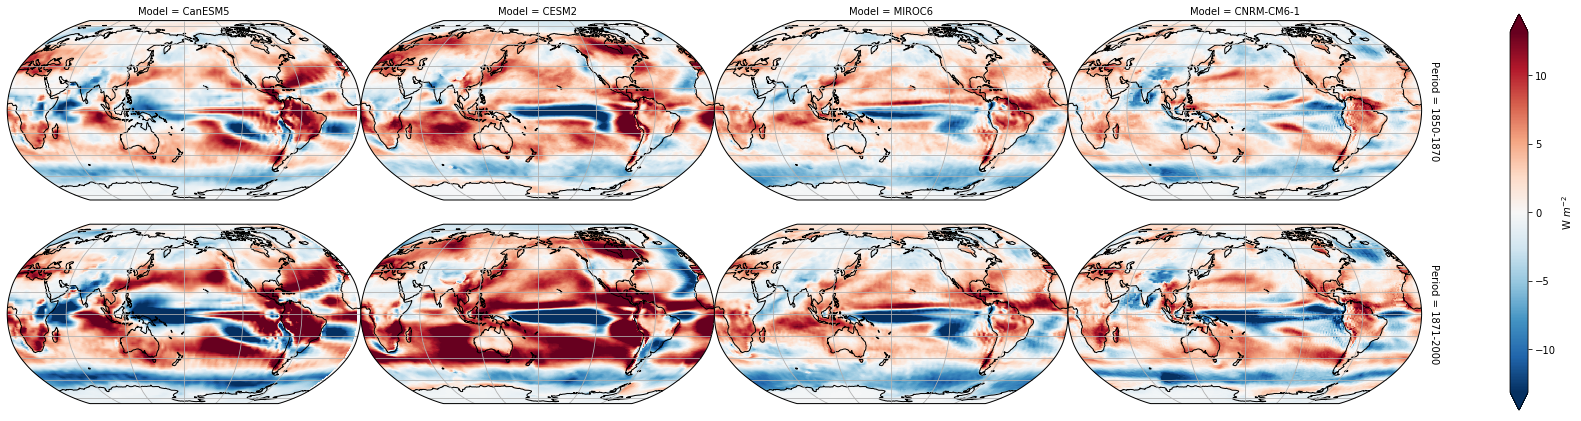

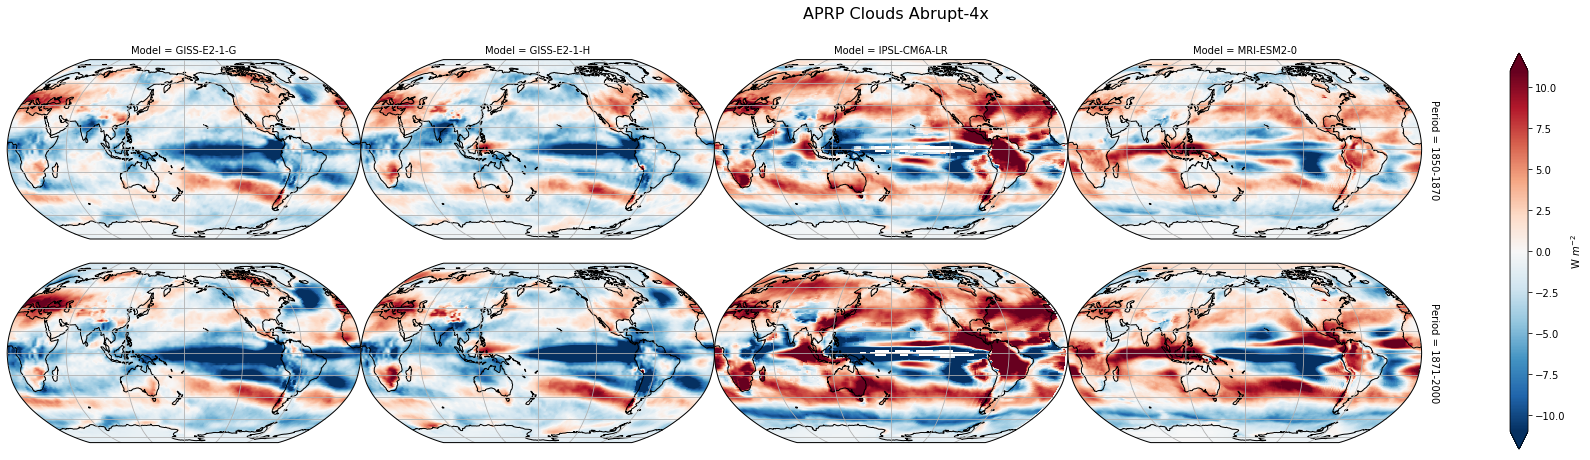

In [15]:
### Figures ###
## Clouds Total ##

mmaprp1d_1 = mmaprp1d.sel(Model = ['CanESM5', 'CESM2', 'MIROC6', 'CNRM-CM6-1'])
mmaprp1d_2 = mmaprp1d.sel(Model = ['GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0'])

map_proj = ccrs.Robinson(central_longitude=180) #Create a map that does not break up the Pacific
plotds_1 = mmaprp1d_1.mean(dim='month')
plotds_2 = mmaprp1d_2.mean(dim='month')

#Plot APRP
p1 = plotds_1.cld.plot(transform = ccrs.PlateCarree(), col = "Model", row = 'Period', robust = True, cmap = 'RdBu_r', 
                       aspect = plotds_1.dims["lon"]/plotds_1.dims["lat"], subplot_kws = {"projection": map_proj},
                       cbar_kwargs = {"label": 'W $m^{-2}$'})

p2 = plotds_2.cld.plot(transform = ccrs.PlateCarree(), col = "Model", row = 'Period', robust = True, cmap = 'RdBu_r', 
                       aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"], subplot_kws = {"projection": map_proj}, 
                       cbar_kwargs = {"label": 'W $m^{-2}$'})

# other kwargs***
# col_wrap=3,  # multiplot settings
# levels=11, #Number of Colors
# center=0, #Set center value of colorbar
# vmin=-15,
# vmax=15,


# We have to set the map's options on all axes

plt.suptitle('APRP Clouds Abrupt-4x', fontsize=16, y=1.05) #Big title at top
for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
#plt.suptitle('APRP Clouds Abrupt-4x extension-piControl', fontsize=16, y=1.05) #Big title at top
#plt.savefig('/home/disk/pynchon/alevine/figures/cmip6_aprp/damip_aprp_multi-modelmean_noncld_scat_annualmean_byperiod_xy.png', bbox_inches='tight')


In [ ]:
## Clouds Scattering ##

plotds_1=mmaprp1d_1.mean(dim='month') #.sel(Period=percor[0])
plotds_2=mmaprp1d_2.mean(dim='month') #.sel(Period=percor[0])

#Plot APRP
p1 = plotds_1.cld_scat.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    row='Period',
    col='Model',
#    col_wrap=3,  # multiplot settings
#    levels=11, #Number of Colors
#    center=0, #Set center value of colorbar
#    vmin=-15,
#    vmax=15,
    robust=True, #account for outliers automatically
    cmap='RdBu_r', #Colormap
    aspect=plotds_1.dims["lon"] /plotds_1.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$'}, #Colorbar Label
)

p2 = plotds_2.cld_scat.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    row='Period',
    col='Model',
#    col_wrap=3,  # multiplot settings
#    levels=11, #Number of Colors
#    center=0, #Set center value of colorbar
#    vmin=-15,
#    vmax=15,
    robust=True, #account for outliers automatically
    cmap='RdBu_r', #Colormap
    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$'}, #Colorbar Label
)

# We have to set the map's options on all axes
plt.suptitle('APRP Clouds Scattering',fontsize=16,y=1.05)
for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()


# We have to set the map's options on all axes
for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()

#plt.savefig('/home/disk/pynchon/alevine/figures/cmip6_aprp/damip_aprp_multi-modelmean_noncld_scat_annualmean_byperiod_xy.png', bbox_inches='tight')
plt.show()



In [ ]:
## Clouds Amount ##

plotds_1=mmaprp1d_1.mean(dim='month') #.sel(Period=percor[0])
plotds_2=mmaprp1d_2.mean(dim='month') #.sel(Period=percor[0])

#Plot APRP
p1 = plotds_1.cld_amt.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    row='Period',
    col='Model',
#    col_wrap=3,  # multiplot settings
#    levels=11, #Number of Colors
#    center=0, #Set center value of colorbar
#    vmin=-15,
#    vmax=15,
    robust=True, #account for outliers automatically
    cmap='RdBu_r', #Colormap
    aspect=plotds_1.dims["lon"] /plotds_1.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$'}, #Colorbar Label
)

p2 = plotds_2.cld_amt.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    row='Period',
    col='Model',
#    col_wrap=3,  # multiplot settings
#    levels=11, #Number of Colors
#    center=0, #Set center value of colorbar
#    vmin=-15,
#    vmax=15,
    robust=True, #account for outliers automatically
    cmap='RdBu_r', #Colormap
    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$'}, #Colorbar Label
)

# We have to set the map's options on all axes
plt.suptitle('APRP Clouds Amount',fontsize=16,y=1.05)
for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()


# We have to set the map's options on all axes
for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()

#plt.savefig('/home/disk/pynchon/alevine/figures/cmip6_aprp/damip_aprp_multi-modelmean_noncld_scat_annualmean_byperiod_xy.png', bbox_inches='tight')
plt.show()



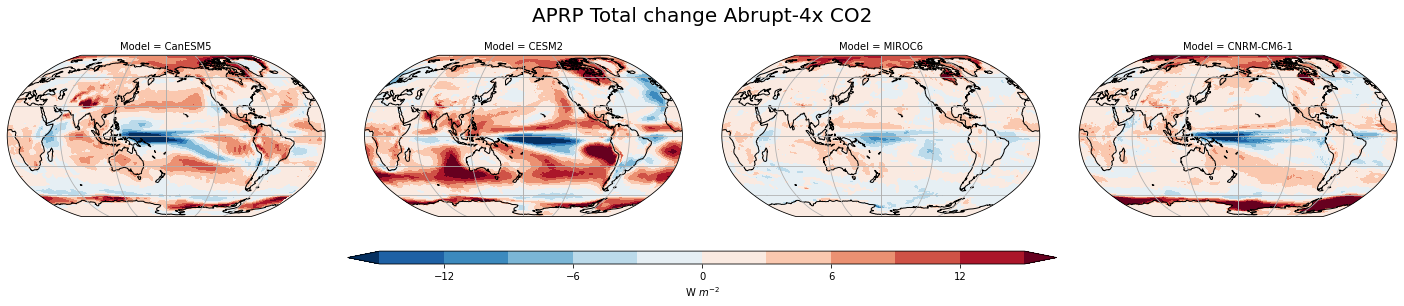

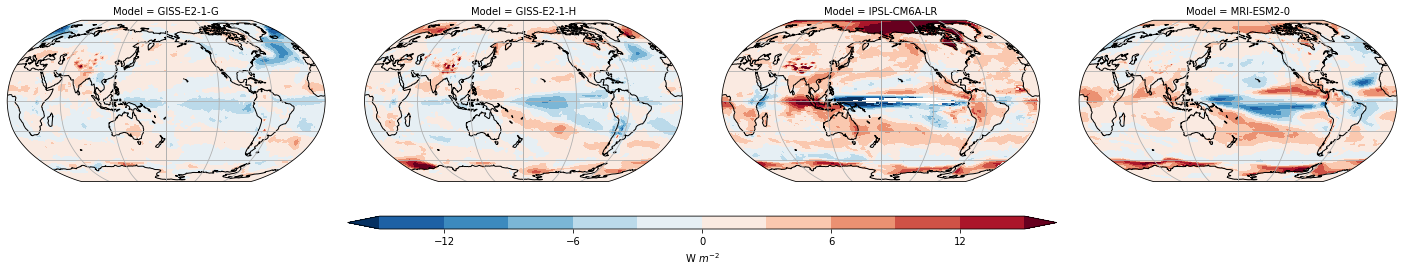

In [9]:
## Clouds Total Change##

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_2.mean(dim='month').sel(Period=percor[0])


#Plot APRP
p1 = plotds_1.total.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-15,
    vmax=15,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)

plt.suptitle('APRP Total change Abrupt-4x CO2', fontsize=20, y=1.15)

p2 = plotds_2.total.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-15,
    vmax=15,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)


for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()


# We have to set the map's options on all axes
for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.savefig('/home/disk/p/apolet/SummerCode/APRP_x4_total.png', bbox_inches='tight')


In [8]:
## Clouds Change ##

plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1])-mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1])-mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

#Plot APRP
p1 = plotds_1.cld.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-15,
    vmax=15,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)

plt.suptitle('APRP Cloud change Abrupt-4x CO2', fontsize=20, y=1.15)

p2 = plotds_2.cld.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-15,
    vmax=15,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)


for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()


# We have to set the map's options on all axes
for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.savefig('/home/disk/p/apolet/SummerCode/APRP_x4_cloud.png', bbox_inches='tight')

NameError: name 'percor' is not defined

In [ ]:
## Clear Sky Change ##

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1])-mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1])-mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

#Plot APRP
p1 = plotds_1.noncld.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-1.5,
    vmax=1.5,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_1.dims["lon"] /plotds_1.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)

plt.suptitle('APRP Non Cloud Change Abrupt-4x CO2', fontsize=20, y=1.15)

p2 = plotds_2.noncld.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-1.5,
    vmax=1.5,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)


for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()

# We have to set the map's options on all axes
for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.savefig('/home/disk/p/apolet/SummerCode/APRP_x4_clear.png', bbox_inches='tight')

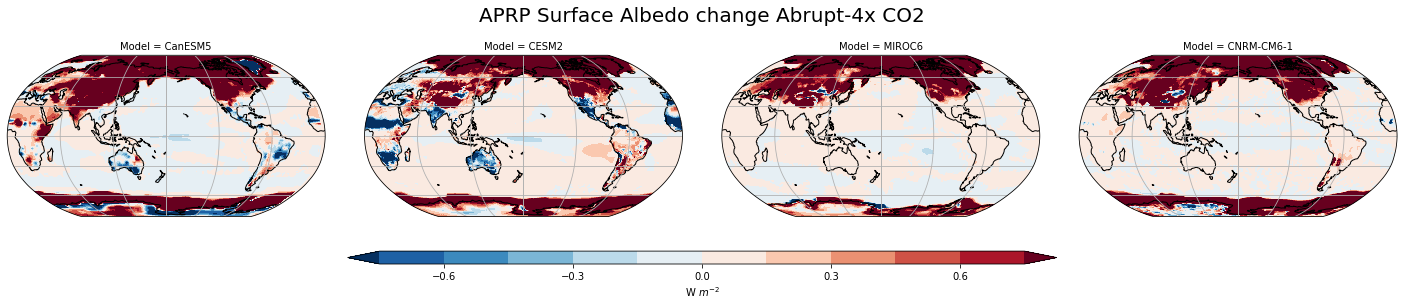

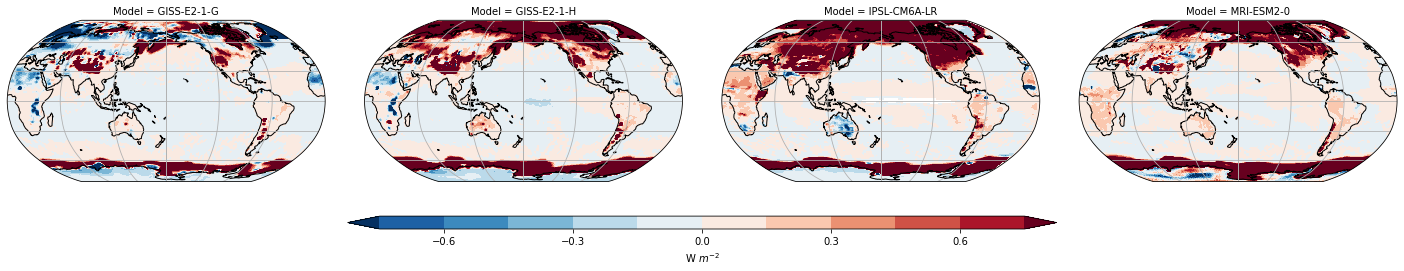

In [10]:
## Surface Albedo Change ##

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1])-mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1])-mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

#Plot APRP
p1 = plotds_1.sfc_alb.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-0.75,
    vmax=0.75,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)

plt.suptitle('APRP Surface Albedo change Abrupt-4x CO2', fontsize=20, y=1.15)

p2 = plotds_2.sfc_alb.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
#    col="Experiment",
    col='Model',
#    col_wrap=3,  # multiplot settings
    levels=11, #Number of Colors
    center=0, #Set center value of colorbar
    vmin=-0.75,
    vmax=0.75,
    robust=True, #account for outliers automatically
    figsize=(20, 3.5),
    cmap='RdBu_r', #Colormap
#    aspect=plotds_2.dims["lon"] /plotds_2.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj}, # the plot's projection
    cbar_kwargs={"label": 'W $m^{-2}$', "location": 'bottom', "aspect": 50, "shrink": 0.5}
)


for ax in p1.axes.flat:
    ax.coastlines()
    ax.gridlines()


# We have to set the map's options on all axes
for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
#plt.savefig('/home/disk/p/apolet/SummerCode/APRP_x2_clear.png', bbox_inches='tight')


In [19]:
## global 

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

#global mean
## 1
zonal_mean1  = plotds_1.mean(dim='lon')


weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1).mean(dim='lat')

print(global_mean1)

## 2
zonal_mean2  = plotds_2.mean(dim='lon')


weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2).mean(dim='lat')

print(global_mean2)

global_mean = xr.concat([global_mean1, global_mean2], dim='Model')
global_mean.to_netcdf('APRP_global_mean_4x.nc')

<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'CanESM5' 'CESM2' 'MIROC6' 'CNRM-CM6-1'
Data variables:
    sfc_alb      (Model) float64 0.9041 0.6114 0.4074 0.9421
    sfc_alb_clr  (Model) float64 0.3998 0.17 0.2341 0.4163
    sfc_alb_oc   (Model) float64 0.5039 0.4414 0.1732 0.5259
    cld          (Model) float64 0.091 2.157 -0.03402 0.04642
    cld_amt      (Model) float64 0.5824 1.307 0.1461 0.1832
    cld_scat     (Model) float64 -0.2812 1.057 -0.1325 -0.03577
    cld_abs      (Model) float64 -0.2102 -0.2074 -0.0476 -0.101
    noncld       (Model) float64 1.057 0.641 0.312 0.5945
    noncld_scat  (Model) float64 0.05417 -0.2881 -0.05337 -0.08386
    noncld_abs   (Model) float64 1.003 0.9291 0.3654 0.6784
    total        (Model) float64 2.052 3.409 0.6854 1.583
<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'GISS-E2-1-G' 'GISS-E2-1-H' ... 'MRI-ESM2-0'
Data variables:
    sfc_alb      (Model) floa

In [20]:
## NH

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

#global mean
## 1
zonal_mean1  = plotds_1.mean(dim='lon')

weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1.where(zonal_mean1.lat > 0)).mean(dim='lat')

print(global_mean1)

## 2
zonal_mean2  = plotds_2.mean(dim='lon')

weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2.where(zonal_mean2.lat > 0)).mean(dim='lat')

print(global_mean2)

NH_mean = xr.concat([global_mean1, global_mean2], dim='Model')
NH_mean.to_netcdf('APRP_NH_mean_4x.nc')

<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'CanESM5' 'CESM2' 'MIROC6' 'CNRM-CM6-1'
Data variables:
    sfc_alb      (Model) float64 1.131 0.657 0.7439 0.8141
    sfc_alb_clr  (Model) float64 0.6137 0.2022 0.4264 0.4103
    sfc_alb_oc   (Model) float64 0.5167 0.4548 0.3175 0.4038
    cld          (Model) float64 0.07128 1.683 0.301 0.2382
    cld_amt      (Model) float64 0.4622 0.918 0.3905 0.2056
    cld_scat     (Model) float64 -0.1419 0.8943 -0.02894 0.1282
    cld_abs      (Model) float64 -0.249 -0.1297 -0.0606 -0.09554
    noncld       (Model) float64 1.121 0.4267 0.351 0.536
    noncld_scat  (Model) float64 0.1339 -0.227 -0.04623 -0.05731
    noncld_abs   (Model) float64 0.9871 0.6537 0.3973 0.5933
    total        (Model) float64 2.316 2.766 1.396 1.588
<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'GISS-E2-1-G' 'GISS-E2-1-H' ... 'MRI-ESM2-0'
Data variables:
    sfc_alb      (Model) float64

In [21]:
## NA

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

print(lons1)

#global mean
## 1
# box from 98 W to 12 E (or 98 to 192)
zonal_mean1  = plotds_1.where(plotds_1.lon > 98).where(plotds_1.lon < 192).mean(dim='lon')

weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1.where(zonal_mean1.lat > 0)).mean(dim='lat')

## 2
zonal_mean2  = plotds_2.mean(dim='lon')

weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2.where(zonal_mean2.lat > 0)).mean(dim='lat')

print(global_mean2)

NA_mean = xr.concat([global_mean1, global_mean2], dim='Model')
NA_mean.to_netcdf('APRP_NA_mean_4x.nc')

<xarray.DataArray 'lon' (lon: 360)>
array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'GISS-E2-1-G' 'GISS-E2-1-H' ... 'MRI-ESM2-0'
Data variables:
    sfc_alb      (Model) float64 0.02333 0.4386 1.072 0.3819
    sfc_alb_clr  (Model) float64 0.03485 0.2769 0.5265 0.17
    sfc_alb_oc   (Model) float64 -0.01152 0.1618 0.5459 0.2119
    cld          (Model) float64 -0.2378 -0.5703 0.7236 0.3943
    cld_amt      (Model) float64 0.2456 0.2593 1.977 0.1149
    cld_scat     (Model) float64 -0.4504 -0.7161 -1.164 0.302
    cld_abs      (Model) float64 -0.03307 -0.1134 -0.08958 -0.02266
    noncld       (Model) float64 0.2439 0.5378 0.8784 0.09418
    noncld_scat  (Model) float64 0.07094 -0.06503 -0.03514 -0.1479
    noncld_abs   (Model) float64 0.1729 0.6029 0.9136 0.2421
    total        (Model) float64 0.02

In [22]:
## SH

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

#global mean
## 1
zonal_mean1  = plotds_1.mean(dim='lon')

weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1.where(zonal_mean1.lat < 0)).mean(dim='lat')

print(global_mean1)

## 2
zonal_mean2  = plotds_2.mean(dim='lon')

weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2.where(zonal_mean2.lat < 0)).mean(dim='lat')

print(global_mean2)

SH_mean = xr.concat([global_mean1, global_mean2], dim='Model')
SH_mean.to_netcdf('APRP_SH_mean_4x.nc')

<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'CanESM5' 'CESM2' 'MIROC6' 'CNRM-CM6-1'
Data variables:
    sfc_alb      (Model) float64 0.6769 0.5657 0.07087 1.07
    sfc_alb_clr  (Model) float64 0.186 0.1379 0.0419 0.4222
    sfc_alb_oc   (Model) float64 0.4911 0.4279 0.02897 0.6479
    cld          (Model) float64 0.1107 2.63 -0.369 -0.1454
    cld_amt      (Model) float64 0.7027 1.696 -0.09839 0.1609
    cld_scat     (Model) float64 -0.4205 1.22 -0.236 -0.1998
    cld_abs      (Model) float64 -0.1714 -0.2851 -0.03459 -0.1065
    noncld       (Model) float64 0.9933 0.8553 0.273 0.653
    noncld_scat  (Model) float64 -0.02556 -0.3493 -0.0605 -0.1104
    noncld_abs   (Model) float64 1.019 1.205 0.3335 0.7634
    total        (Model) float64 1.788 4.052 -0.02515 1.578
<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'GISS-E2-1-G' 'GISS-E2-1-H' ... 'MRI-ESM2-0'
Data variables:
    sfc_alb      (Model) flo

In [23]:
## Tropics

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d_1.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_1.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d_2.mean(dim='month').sel(Period=percor[1]) - mmaprp1d_2.mean(dim='month').sel(Period=percor[0])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

#global mean
## 1
zonal_mean1  = plotds_1.mean(dim='lon')

weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1.where(zonal_mean1.lat < 20))
global_mean1 = (global_mean1.where(zonal_mean1.lat > -20).mean(dim='lat'))

print(global_mean1)

## 2
zonal_mean2  = plotds_2.mean(dim='lon')

weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2.where(zonal_mean2.lat < 20))
global_mean2 = (global_mean2.where(zonal_mean2.lat > -20).mean(dim='lat'))

print(global_mean2)

SH_mean = xr.concat([global_mean1, global_mean2], dim='Model')
SH_mean.to_netcdf('APRP_TR_mean_4x.nc')

<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'CanESM5' 'CESM2' 'MIROC6' 'CNRM-CM6-1'
Data variables:
    sfc_alb      (Model) float64 0.02902 -0.08793 0.02243 0.02873
    sfc_alb_clr  (Model) float64 0.02671 -0.07098 0.01661 0.02163
    sfc_alb_oc   (Model) float64 0.002733 -0.01695 0.005819 0.007102
    cld          (Model) float64 -0.3342 3.529 0.1581 -0.6728
    cld_amt      (Model) float64 0.4199 1.291 0.3858 -0.5123
    cld_scat     (Model) float64 -0.2628 2.715 -0.1475 0.06077
    cld_abs      (Model) float64 -0.4913 -0.4773 -0.08024 -0.2213
    noncld       (Model) float64 1.652 1.147 0.6257 1.126
    noncld_scat  (Model) float64 -0.07531 -0.5093 -0.09579 -0.07753
    noncld_abs   (Model) float64 1.728 1.656 0.7215 1.204
    total        (Model) float64 1.362 4.588 0.8062 0.4821
<xarray.Dataset>
Dimensions:      (Model: 4)
Coordinates:
  * Model        (Model) object 'GISS-E2-1-G' 'GISS-E2-1-H' ... 'MRI-ESM2-0'
Data variables:
    sfc

In [21]:
## global

## global 

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d.mean(dim='month').sel(Period=percor[1])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

#global mean
## 1
zonal_mean1  = plotds_1.mean(dim='lon')


weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1).mean(dim='lat')

print(global_mean1.total, '\n')

## 2
zonal_mean2  = plotds_2.mean(dim='lon')


weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2).mean(dim='lat')

print(global_mean2.total, '\n')

## NH midlats

percor = ['1850-1870','1871-2000'] #When creating a xarray dataset with a period coordinate-coordinate name
plotds_1 = mmaprp1d.mean(dim='month').sel(Period=percor[0])
plotds_2 = mmaprp1d.mean(dim='month').sel(Period=percor[1])

lons1 = plotds_1['lon']
lats1 = plotds_1['lat']

lons2 = plotds_2['lon']
lats2 = plotds_2['lat']

#global mean
## 1
zonal_mean1  = plotds_1.mean(dim='lon')

weight1 = np.cos(np.deg2rad(lats1))
weight1 = weight1 / weight1.mean() # normalize so weights have a mean of 1

global_mean1 = (weight1 * zonal_mean1.where(zonal_mean1.lat > 30)).mean(dim='lat')

print(global_mean1.total, '\n')

## 2
zonal_mean2  = plotds_2.mean(dim='lon')

weight2 = np.cos(np.deg2rad(lats2))
weight2 = weight2 / weight2.mean() # normalize so weights have a mean of 1

global_mean2 = (weight2 * zonal_mean2.where(zonal_mean2.lat > 30)).mean(dim='lat')

print(global_mean2.total, '\n')



<xarray.DataArray 'total' (Model: 8)>
array([4.5608972 , 4.25701857, 2.69311572, 3.9985057 , 0.42187161,
       0.46390114, 3.98818179, 3.26358007])
Coordinates:
  * Model    (Model) object 'CanESM5' 'CESM2' ... 'IPSL-CM6A-LR' 'MRI-ESM2-0'
    Period   <U9 '1850-1870' 

<xarray.DataArray 'total' (Model: 8)>
array([6.61305998, 7.66592071, 3.37849816, 5.58137222, 0.29840774,
       0.74618928, 6.18124537, 4.28925777])
Coordinates:
  * Model    (Model) object 'CanESM5' 'CESM2' ... 'IPSL-CM6A-LR' 'MRI-ESM2-0'
    Period   <U9 '1871-2000' 

<xarray.DataArray 'total' (Model: 8)>
array([6.39460861, 5.87241156, 4.20936612, 4.86656153, 2.74014475,
       2.58930676, 6.28310437, 4.61612043])
Coordinates:
  * Model    (Model) object 'CanESM5' 'CESM2' ... 'IPSL-CM6A-LR' 'MRI-ESM2-0'
    Period   <U9 '1850-1870' 

<xarray.DataArray 'total' (Model: 8)>
array([8.94345609, 7.27230627, 5.53018874, 6.39510227, 2.5469444 ,
       3.17451412, 9.06630756, 4.88124886])
Coordinates:
  * Model    (Model) obje

In [25]:
7.27230627 - 7.66592071

-0.39361444000000034